# Fluctuation-driven Initialization for SNNs

This notebook provides a brief interactive tutorial for initialization of SNNs in the fluctuation-driven regime.

In [1]:
# Imports
import sys

sys.path.append("../../stork-1")

import numpy as np
import matplotlib.pyplot as plt
import stork.utils

using my stork version - EI-assemblies


In [2]:
# for reproducibility
np.random.seed(2020)

We first define some general simulation and plotting paramters

In [3]:
# Simulation parameters
dt = timestep = 1e-3  # timestep in s
duration = 10  # Duration in seconds
epsilon_calc_method = (
    "numerical"  # Choose between numerical or analytical way of computing epsilon
)

# Cosmetics and plotting
spike_amp = 2.0
plot_maxtime = 2.0  # seconds
plot_maxneurons = 100  # neurons

color_membrane = "#CCB380"
color_theta = "#454545"
line_colors = ["#969696", "#525252", "black"]

## Poisson distributed input spikes

As an example input, we generate homogenous Poisson spike trains and visualize them in a spike raster. We first set parameters of the input, i.e. the number of input neurons and their firing rate

In [4]:
# Input parameters

N = 5000  # Nb. presynaptic neurons
nu = 3  # presynaptic firing rate

Next, we define functions for spike generation and plotting

In [5]:
def get_poisson_spikes(N, nu, duration, dt):
    """Generates a set of Poisson-distributed spikes for $N$ neurons that fire at frequency $\nu$.

    Args:
        N (int): Number of input neurons
        nu (float): Firing rate of input neurons in Hz
        duration (float): Duration of simulation in seconds
        dt (float): Simulation time step in seconds

    Returns:
        np.array: Array containing Poisson distributed spikes
    """
    timesteps = int(duration / dt)
    spikes = np.zeros((timesteps, N))
    spikeprob_per_timestep = nu * dt

    for t in range(timesteps):
        spikes[t] = np.random.rand(N) < spikeprob_per_timestep

    return spikes


def plot_spikeraster(spikes, timestep, axis, max_time=1, max_neurons=500):
    """Generates a spike raster plot

    Args:
        spikes: Binary array containing spikes
        timestep (float): Simulation time step.
        axis: Axis to plot on.
        max_time (int, optional): Maximal number of time steps to display. Defaults to 1.
        max_neurons (int, optional): Maximal number of neurons to display. Defaults to 500.

    Returns:
        _type_: _description_
    """
    max_timesteps = int(max_time / timestep)  # max timestep calculation

    spiketimes = []  # convert to spike times
    for t in range(max_timesteps):
        spiking_neurons = np.where(spikes[t] == 1)[0]
        for idx in spiking_neurons:
            if idx <= max_neurons:
                spiketimes.append((t, idx))
    spiketimes = np.array(spiketimes)

    time_axis = (
        spiketimes[:, 0] * timestep
    )  # get x and y axis: multiply by timestep to get seconds
    neuron_axis = spiketimes[:, 1]

    axis.scatter(time_axis, neuron_axis, s=1.5, c="k")  # plot
    axis.set_ylabel("neuron idx")
    axis.set_xlabel("time [s]")

    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)

    return axis

Finally, we generate example inputs and plot a spike raster

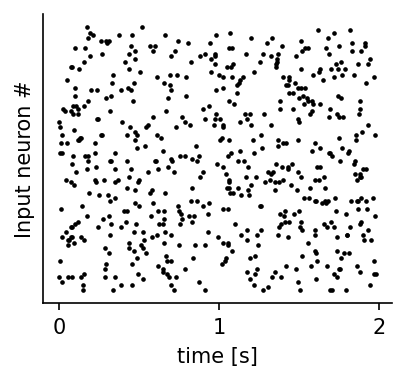

In [6]:
# generate Poisson Spike Trains
spikes = get_poisson_spikes(N, nu, duration, timestep)

# and plot them (at least the first 100 neurons and first 2 seconds)
plot_maxtime = 2.0  # seconds
plot_maxneurons = 100  # neurons

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=150)
plot_spikeraster(
    spikes, timestep, ax, max_time=plot_maxtime, max_neurons=plot_maxneurons
)
ax.set_xticks(np.arange(0, plot_maxtime + 1, 1))
ax.set_yticks([])
ax.set_ylabel("Input neuron #")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

## Neuronal dynamics

To successfully initialize postsynaptic neurons in the fluctuation-driven regime, we take into account input parameters and neuronal dynamics to define the synaptic weight distribution.

We first set the parameters of the LIF neuron model:

In [7]:
# LIF parameters
tau_syn = 10e-3
tau_mem = 20e-3
theta = 1.0  # threshold
refractory_period = 2e-3  # refractory period in s

The neuronal dynamics are captured by a kernel describing the shape of the post-synaptic potential (PSP) evoked by each spike. For weight initialization, we require the integral of the PSP-kernel $\epsilon$ and the squared PSP-kernel $\epsilon^2$, which we refer to as $\bar\epsilon$ and $\hat\epsilon$ respectively. 

The values of $\bar\epsilon$ and $\hat\epsilon$ can be computed numerically or analytically. For practical purposes, numerical estimation with the same time step used for SNN training leads to more accurate results.

In [8]:
def epsilon_analytical(tau_mem, tau_syn):
    epsilon_bar = tau_syn
    epsilon_hat = (tau_syn**2) / (2 * (tau_syn + tau_mem))

    return epsilon_bar, epsilon_hat


def epsilon_numerical(tau_mem, tau_syn):
    kernel = stork.utils.get_lif_kernel(tau_mem, tau_syn, timestep)
    epsilon_bar = kernel.sum() * timestep
    epsilon_hat = (kernel**2).sum() * timestep

    return epsilon_bar, epsilon_hat


def get_epsilon(tau_mem, tau_syn, calc_mode="numerical"):
    if calc_mode == "analytical":
        return epsilon_analytical(tau_mem, tau_syn)
    elif calc_mode == "numerical":
        return epsilon_numerical(tau_mem, tau_syn)
    else:
        raise ValueError("invalid calc mode for epsilon")


print(r"$\bar\epsilon$", end=": ")
print(get_epsilon(tau_mem, tau_syn)[0])
print(r"$\hat\epsilon$", end=": ")
print(get_epsilon(tau_mem, tau_syn)[1])

$\bar\epsilon$: 0.010507353352192265
$\hat\epsilon$: 0.001841948059032449


## Weight initialization

We can now initialize the synaptic weights given a target membrane potential distribution that ensures sparse, fluctuation-driven firing.

In [9]:
# Initialization target parameters
mu_U = 0.0  # Target mean of membrane potential distribution
xi = 2.0  # Target distance between membrane potential mean (mu_U) and firing threshold (1.0)
# in units of standard deviation

In [10]:
def get_sigma_w(theta, xi, N, nu, mu_U, epsilon_hat, mu_w):
    """Calculate standard deviation of the weight distribution, that can be used for initialization.

    Args:
        theta (float): Threshold.
        xi (float): Initialization parameter, usually 1<xi<3.
        N (int): Number of inputs.
        nu (float): Input firing rate.
        mu_U (float): Target mean membrane potential.
        epsilon_hat (float): Integral of the squared PSP-kernel.
        mu_w (float): Mean of the weight distribution.

    Returns:
        float: Standard deviation of the weight distribution.
    """

    sigma2_w = 1 / (N * nu * epsilon_hat) * ((theta - mu_U) / xi) ** 2 - mu_w**2
    sigma_w = np.sqrt(sigma2_w)
    return sigma_w


def get_mu_w(N, nu, mu_U, epsilon_bar):
    """Calculate the mean of the weight distribution, that can be used for initialization.

    Args:
        N (int): Number of input neurons.
        nu (float): Input firing rate.
        mu_U (float): Target mean membrane potential.
        epsilon_bar (float): Integral of the PSP-Kernel.

    Returns:
        float: Mean of the weight distribution.
    """
    mu_w = mu_U / (N * nu * epsilon_bar)
    return mu_w


def sample_normal(N, mu, sigma):
    return mu + np.random.randn(N) * sigma


def get_w_params(N, nu, theta, mu_U, xi, tau_mem, tau_syn, eps_calc_mode="numerical"):
    """
    Get mean and standard deviation for the synaptic weight distribution based on
    a target in the fluctuation-driven reigme (defined by mu_U and xi)

    Args:
        N (int): Number of inputs.
        nu (float, optional): Input firing rate. Defaults to None.
        theta (float, optional): Threshold. Defaults to None.
        mu_U (float, optional): Target mean membrane potential. Defaults to None.
        xi (float, optional): Initialization parameter, usually 1<xi<3. Defaults to None.
        tau_mem (float, optional): Membrane time constant. Defaults to None.
        tau_syn (float, optional): Synaptic time constant. Defaults to None.
        eps_calc_mode (str, optional): Calculation mode of epsilons. Defaults to "numerical".

    Returns:
        weights
    """
    epsilon_bar, epsilon_hat = get_epsilon(
        calc_mode=eps_calc_mode, tau_mem=tau_mem, tau_syn=tau_syn
    )
    mu_w = get_mu_w(N, nu, mu_U, epsilon_bar)
    sigma_w = get_sigma_w(theta, xi, N, nu, mu_U, epsilon_hat, mu_w)

    return mu_w, sigma_w

For illustrative purposes, let's define a nice plotting function for distributions

In [11]:
def plot_histogram_with_gaussian(
    data,
    mu,
    sigma,
    axis,
    color,
    linecolor,
    bins=40,
    orientation="vertical",
    minmax=None,
    valrange=None,
    linewidth=1.0,
    edgecolor="white",
):
    if minmax is None:
        minmax = (np.round(-4 * sigma, 1), np.around(4 * sigma, 1))

    xax = np.arange(minmax[0], minmax[1], 0.01)
    axis.hist(
        data,
        bins=bins,
        color=color,
        density=True,
        orientation=orientation,
        range=valrange,
        label="Simulation",
        edgecolor=edgecolor,
    )

    if orientation == "horizontal":
        pdf = gaussian_pdf(xax, mu, sigma)
        axis.plot(pdf, xax, color=linecolor, lw=linewidth, label="Theory")

        # remove bottom axis
        axis.get_xaxis().set_visible(False)
        axis.spines["bottom"].set_visible(False)
        axis.set_ylim(minmax[0], minmax[1])
        axis.set_yticks([minmax[0], mu, minmax[1]])

    else:
        pdf = gaussian_pdf(xax, mu, sigma)
        axis.plot(xax, pdf, color=linecolor, lw=linewidth, label="Theory")

        # remove left axis
        axis.get_yaxis().set_visible(False)
        axis.spines["left"].set_visible(False)

        axis.set_xlim(minmax[0], minmax[1])
        axis.set_xticks([minmax[0], mu, minmax[1]])

    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    return axis


def gaussian_pdf(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

Finally, we can sample the synaptic weights taking into account the input parameters and neuronal dynamics

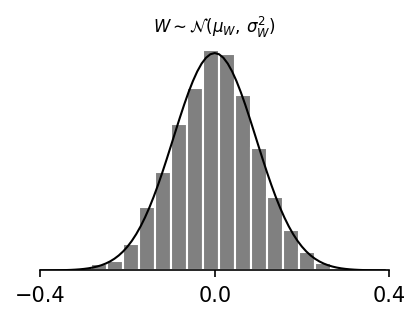

In [12]:
# Get synaptic weights
eps_calc_mode = "numerical"
mu_w, sigma_w = get_w_params(
    N=N,
    nu=nu,
    theta=theta,
    mu_U=mu_U,
    xi=xi,
    tau_mem=tau_mem,
    tau_syn=tau_syn,
    eps_calc_mode=eps_calc_mode,
)
weights = sample_normal(N, mu_w, sigma_w)

# Plot synaptic weights
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
plot_histogram_with_gaussian(weights, mu_w, sigma_w, ax, "grey", "black", bins=20)

ax.set_title(
    r"$W \sim \mathcal{N}(\mu_W,\,\sigma_W^{2})$",
    color="black",
    fontsize=8,
    verticalalignment="center",
    horizontalalignment="center",
)

plt.show()

## Membrane Potential follows a Gaussian

Before we can have a look at the membrane potential, let us define some functions, that compute it.

In [13]:
def get_membrane(I, tau_mem, theta, dt, refractory_period=0, spike_amp=2):
    """Compute the membrane potential.

    Args:
        I: Input current.
        tau_mem (float): Membrane time constant.
        theta (float): Threshold.
        dt (float): Simulation time step.
        refractory_period (float, optional): Refractory period. Defaults to 0.
        spike_amp (float, optional): Height of a spike. Defaults to 2.

    Returns:
        Membrane potential.
    """
    u = np.zeros(I.shape)
    decay = np.exp(-dt / tau_mem)
    refrac = 0

    for t in range(1, u.shape[0]):
        if refrac > 0:  # Implement refractory period
            u[t] = 0
        else:
            u[t] = u[t - 1] * decay + (1 - decay) * I[t]  # update
            if u[t] >= theta:  # spikes
                u[t] = spike_amp
                refrac = refractory_period
        refrac -= dt  # decay refrac
    return u


def get_current(spikes, weights, tau_syn, dt):
    """Compute synaptic currents.

    Args:
        spikes: Incoming spike trains.
        weights: Synaptic weights.
        tau_syn (float): Synaptic time constant.
        dt (float): Simulation time step.

    Returns:
        Synaptic current.
    """
    currents = np.zeros(spikes.shape)
    decay = np.exp(-dt / tau_syn)

    for t in range(1, currents.shape[0]):
        currents[t] = currents[t - 1] * decay + spikes[t]

    currents *= weights.T
    return currents.sum(1)  # Sum over all input neurons to get total input current

Furthermore we want to compute the theoretical mean and variance of the membrane potential,

In [14]:
def get_mu_U(N, nu, epsilon_bar, mu_w):
    return N * nu * epsilon_bar * mu_w


def get_sigma_U(N, nu, epsilon_hat, mu_w, sigma_w):
    return np.sqrt(N * (mu_w**2 + sigma_w**2) * nu * epsilon_hat)

before we finally plot the membrane potential and how it is Gaussian distributed.

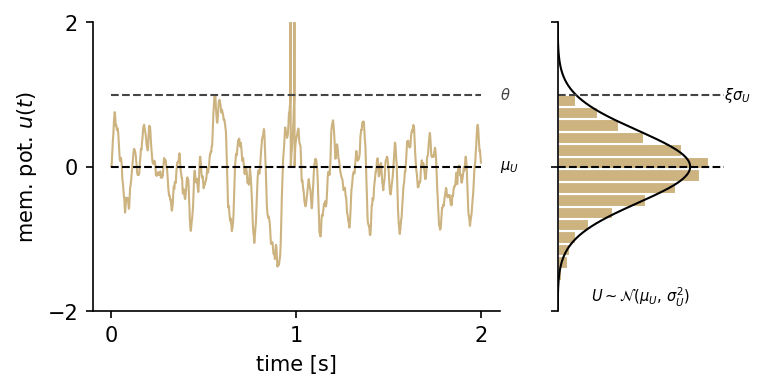

In [15]:
fig, ax = plt.subplots(
    1, 2, figsize=(5.5, 2.5), dpi=150, gridspec_kw={"width_ratios": [0.7, 0.3]}
)

# get membrane potential values and parameters
currents = get_current(spikes, weights, tau_syn, timestep)
out_with_spikes = get_membrane(
    I=currents,
    tau_mem=tau_mem,
    theta=theta,
    dt=dt,
    refractory_period=refractory_period,
    spike_amp=spike_amp,
)
out_without_spikes = out_with_spikes.copy()
out_without_spikes[out_without_spikes == spike_amp] = 0
epsilon_bar, epsilon_hat = get_epsilon(
    calc_mode=eps_calc_mode, tau_mem=tau_mem, tau_syn=tau_syn
)
mu_U = get_mu_U(N=N, nu=nu, epsilon_bar=epsilon_bar, mu_w=mu_w)
sigma_U = get_sigma_U(N=N, nu=nu, epsilon_hat=epsilon_hat, mu_w=mu_w, sigma_w=sigma_w)

# specify plot parameters
figsize = (3.5, 1.4)
time_axis = np.arange(0, plot_maxtime, timestep)
minmax = (-2, 2)

# plot membrane potential
ax[0].plot(time_axis, out_with_spikes[: len(time_axis)], color=color_membrane, lw=1)
ax[0].hlines(theta, 0, plot_maxtime, color=color_theta, lw=1, ls="dashed", zorder=10)
ax[0].hlines(0, 0, plot_maxtime, color="black", lw=1, ls="dashed", zorder=10)

ax[0].set_ylim(minmax[0], minmax[1])
ax[0].set_xlabel("time [s]")
ax[0].set_ylabel(r"mem. pot. $u(t)$")
ax[0].set_xticks(np.arange(0, plot_maxtime + 1, 1))
ax[0].set_yticks([minmax[0], 0, minmax[1]])


# plot histogram of membrane potential with corresponding theoretical curve
plot_histogram_with_gaussian(
    out_without_spikes,
    mu_U,
    sigma_U,
    ax[-1],
    color_membrane,
    "black",
    orientation="horizontal",
    minmax=minmax,
    bins=15,
)
ax[1].hlines(theta, 0, 1, color=color_theta, lw=1, ls="dashed")
ax[1].hlines(0, 0, 1, color="black", lw=1, ls="dashed", zorder=10)
ax[1].axes.yaxis.set_ticklabels([])
ax[1].set_ylim(minmax[0], minmax[1])

ax[0].text(
    plot_maxtime + 0.1,
    theta,
    r"$\theta$",
    color=color_theta,
    fontsize=7,
    verticalalignment="center",
)
ax[0].text(
    plot_maxtime + 0.1,
    0,
    r"$\mu_U$",
    color="black",
    fontsize=7,
    verticalalignment="center",
)
ax[1].text(
    0.2,
    minmax[0] + 0.2,
    r"$U \sim \mathcal{N}(\mu_U,\,\sigma_U^{2})$",
    color="black",
    fontsize=7,
    verticalalignment="center",
)
ax[1].text(
    1.0, theta, r"$\xi \sigma_U$", color="black", fontsize=7, verticalalignment="center"
)

# Remove top and right spines
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

plt.show()

## Different values for $\xi$

Now we can have a look at the membrane potential distribution for different values of $\xi$.

In [16]:
def get_mempot_range(membrane):
    absmax = np.abs(membrane).max().round(1)
    return (-absmax, absmax)


def get_membrane_without_spikes(I, tau_mem, dt):
    """
    Only implement leaky membrane, without refractory period or spike reset
    """
    u = np.zeros(I.shape)
    decay = np.exp(-dt / tau_mem)

    for t in range(1, u.shape[0]):
        u[t] = u[t - 1] * decay + (1 - decay) * I[t]

    return u


def run_simulation(
    mu_U,
    xi,
    tau_mem,
    tau_syn,
    N,
    nu,
    duration,
    dt,
    theta,
    spike_amp,
    calc_mode="numerical",
):
    # Get initial weights
    mu_w, sigma_w = get_w_params(
        N, nu, theta, mu_U, xi, tau_mem, tau_syn, eps_calc_mode="numerical"
    )
    weights = sample_normal(N, mu_w, sigma_w)

    # Get spikes, currents and membrane potential
    spikes = get_poisson_spikes(N=N, nu=nu, duration=duration, dt=dt)
    currents = get_current(spikes=spikes, weights=weights, tau_syn=tau_syn, dt=dt)
    membrane = get_membrane_without_spikes(I=currents, tau_mem=tau_mem, dt=dt)

    # Get membrane potential considering reset and output firing rate
    out_with_spikes = get_membrane(
        I=currents,
        tau_mem=tau_mem,
        theta=theta,
        dt=dt,
        refractory_period=refractory_period,
        spike_amp=spike_amp,
    )
    out_without_spikes = out_with_spikes.copy()
    out_without_spikes[out_without_spikes == spike_amp] = 0

    # Analytical calculation of mu_U and sigma_u
    mu_U = get_mu_U(N=N, nu=nu, epsilon_bar=epsilon_bar, mu_w=mu_w)
    sigma_U = get_sigma_U(
        N=N, nu=nu, epsilon_hat=epsilon_hat, mu_w=mu_w, sigma_w=sigma_w
    )

    return membrane, out_without_spikes, mu_U, sigma_U

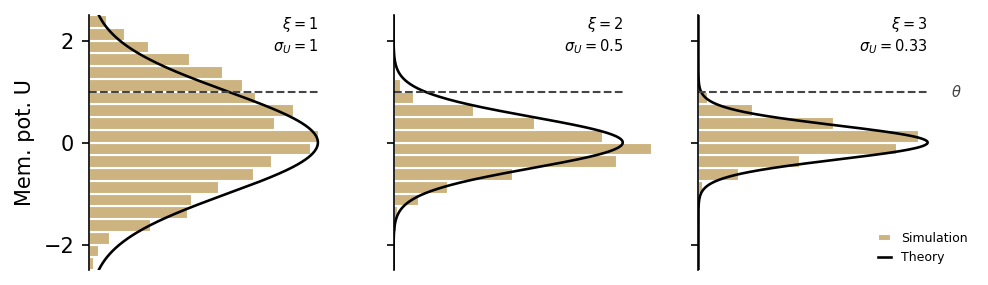

In [17]:
# plot membrane potential with different values of xi
fig, ax = plt.subplots(1, 3, figsize=(6.69, 2.0), dpi=150)

# plot parameters
xis = (1.0, 2.0, 3.0)
umus = (0.0, 0.0, 0.0)
ymin, ymax = -2.5, 2.5
yticks = [-2, 0, 2]

for idx, xi, umu in zip(np.arange(3), xis, umus):
    # run simulation
    membrane, out_without_spikes, mu_U, sigma_U = run_simulation(
        mu_U=umu,
        xi=xi,
        tau_mem=tau_mem,
        tau_syn=tau_syn,
        N=N,
        nu=nu,
        duration=duration,
        dt=dt,
        theta=theta,
        spike_amp=spike_amp,
        calc_mode="numerical",
    )

    # plot histogram and theoretical curve
    minmax = get_mempot_range(membrane)
    plot_histogram_with_gaussian(
        membrane,
        mu=mu_U,
        sigma=sigma_U,
        axis=ax[idx],
        color=color_membrane,
        linecolor="black",
        bins=20,
        minmax=(ymin, ymax),
        valrange=(ymin, ymax),
        orientation="horizontal",
        linewidth=1.25,
    )

    xmax = gaussian_pdf(np.arange(ymin, ymax, 0.01), mu_U, sigma_U).max()

    ax[idx].hlines(1.0, 0, xmax, ls="dashed", color=color_theta, lw=1)
    ax[idx].set_xlim(0, xmax * 1.2)
    ax[idx].set_yticks(yticks)

    if xi == 1.0:
        f = lambda float: int(float)
    else:
        f = lambda float: np.round(float, 2)
    ax[idx].text(
        xmax,
        ymax,
        r"$\xi={}$".format(int(xi)) + "\n" + r"$\sigma_U={}$".format(f(1 / xi)),
        fontsize=7,
        verticalalignment="top",
        horizontalalignment="right",
    )

    ax[idx].spines["top"].set_visible(False)
    ax[idx].spines["right"].set_visible(False)

ax[-1].text(
    xmax * 1.1,
    theta,
    r"$\theta$",
    color=color_theta,
    fontsize=7,
    verticalalignment="center",
)
ax[1].axes.yaxis.set_ticklabels([])
ax[2].axes.yaxis.set_ticklabels([])
ax[0].set_ylabel(r"Mem. pot. U")
ax[-1].legend(
    fontsize=6,
    borderpad=0.0,
    loc="lower right",
    handlelength=1.0,
    handleheight=0.5,
    frameon=False,
)

plt.tight_layout()
plt.show()

Let's run another batch of simulations, this time looking at the membrane potential when considering the spike reset

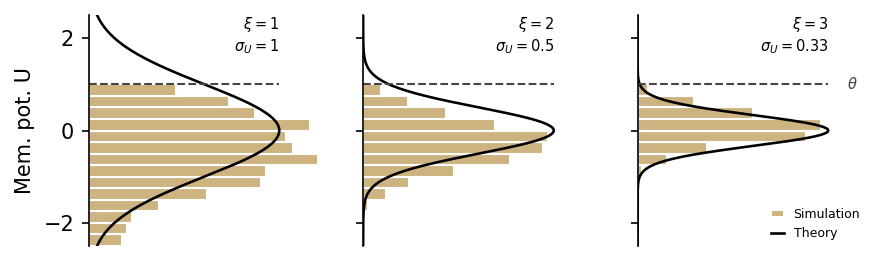

In [18]:
# plot membrane potential with different values of xi
fig, ax = plt.subplots(1, 3, figsize=(6.69, 2.0), dpi=150)

for idx, xi, umu in zip(np.arange(3), xis, umus):
    # run simulation
    membrane, out_without_spikes, mu_U, sigma_U = run_simulation(
        mu_U=umu,
        xi=xi,
        tau_mem=tau_mem,
        tau_syn=tau_syn,
        N=N,
        nu=nu,
        duration=duration,
        dt=dt,
        theta=theta,
        spike_amp=spike_amp,
        calc_mode="numerical",
    )

    # plot histogram and theoretical curve
    minmax = get_mempot_range(out_without_spikes)
    plot_histogram_with_gaussian(
        out_without_spikes,
        mu=mu_U,
        sigma=sigma_U,
        axis=ax[idx],
        color=color_membrane,
        linecolor="black",
        bins=20,
        minmax=(ymin, ymax),
        valrange=(ymin, ymax),
        orientation="horizontal",
        linewidth=1.25,
    )

    xmax = gaussian_pdf(np.arange(ymin, ymax, 0.01), mu_U, sigma_U).max()

    ax[idx].hlines(1.0, 0, xmax, ls="dashed", color=color_theta, lw=1)
    ax[idx].set_xlim(0, xmax * 1.2)
    ax[idx].set_yticks(yticks)

    if xi == 1.0:
        f = lambda float: int(float)
    else:
        f = lambda float: np.round(float, 2)
    ax[idx].text(
        xmax,
        ymax,
        r"$\xi={}$".format(int(xi)) + "\n" + r"$\sigma_U={}$".format(f(1 / xi)),
        fontsize=7,
        verticalalignment="top",
        horizontalalignment="right",
    )

    ax[idx].spines["top"].set_visible(False)
    ax[idx].spines["right"].set_visible(False)

ax[-1].text(
    xmax * 1.1,
    theta,
    r"$\theta$",
    color=color_theta,
    fontsize=7,
    verticalalignment="center",
)
ax[1].axes.yaxis.set_ticklabels([])
ax[2].axes.yaxis.set_ticklabels([])
ax[0].set_ylabel(r"Mem. pot. U")
ax[-1].legend(
    fontsize=6,
    borderpad=0.0,
    loc="lower right",
    handlelength=1.0,
    handleheight=0.5,
    frameon=False,
)


plt.show()